In [40]:
!pip install opencv-python mediapipe numpy pillow matplotlib opencv-contrib-python
!apt-get update -qq && apt-get install -y libgl1-mesa-glx


W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
libgl1-mesa-glx is already the newest version (23.0.4-0ubuntu1~22.04.1).
0 upgraded, 0 newly installed, 0 to remove and 46 not upgraded.


In [41]:
import cv2
import numpy as np
import mediapipe as mp
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow
from google.colab import files


In [56]:
class SunglassesDrawer:
    def __init__(self):
        self.face_mesh = mp.solutions.face_mesh.FaceMesh(
            static_image_mode=False,
            max_num_faces=1,
            refine_landmarks=True,
            min_detection_confidence=0.8,
            min_tracking_confidence=0.7
        )
        # Landmark indices
        self.EYE_L = {'center': 468, 'outer': 33, 'inner': 133}
        self.EYE_R = {'center': 473, 'outer': 362, 'inner': 263}
        self.EAR_L = 234  # approximate left ear region
        self.EAR_R = 454  # approximate right ear region

    def draw(self, img):
        h, w = img.shape[:2]
        results = self.face_mesh.process(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        if not results.multi_face_landmarks: return img

        lm = results.multi_face_landmarks[0].landmark
        # Convert to pixel
        def px(idx): return np.array([lm[idx].x * w, lm[idx].y * h])
        cL, cR = px(self.EYE_L['center']), px(self.EYE_R['center'])
        oL, iL = px(self.EYE_L['outer']), px(self.EYE_L['inner'])
        oR, iR = px(self.EYE_R['outer']), px(self.EYE_R['inner'])
        earL, earR = px(self.EAR_L), px(self.EAR_R)

        # Compute inter-eye distance
        dist = np.linalg.norm(cR - cL)
        radius = int(dist * 0.4)  # circle radius 40% of eye distance

        # Draw double circles for lenses
        thickness = max(2, int(radius * 0.1))
        for center in [cL, cR]:
            cv2.circle(img, tuple(center.astype(int)), radius, (0,0,0), -1)
            cv2.circle(img, tuple(center.astype(int)), radius, (60,60,60), thickness)

        # Bridge lines: double lines between lenses
        vec = (cR - cL) / np.linalg.norm(cR - cL)
        p1 = cL + vec * radius * 0.9
        p2 = cR - vec * radius * 0.9
        b_thick = max(2, int(radius * 0.08))
        cv2.line(img, tuple(p1.astype(int)), tuple(p2.astype(int)), (0,0,0), b_thick)
        cv2.line(img, tuple((p1 + vec*radius*0.05).astype(int)),
                 tuple((p2 - vec*radius*0.05).astype(int)), (0,0,0), b_thick)

        # Temple lines: double lines to ears
        for start, ear in [(p1, earL), (p2, earR)]:
            line_vec = ear - start
            mid = start + line_vec * 0.6
            t_thick = max(2, int(radius * 0.08))
            # first line
            cv2.line(img, tuple(start.astype(int)), tuple(mid.astype(int)), (0,0,0), t_thick)
            # second line parallel with small offset
            perp = np.array([-vec[1], vec[0]]) * radius*0.02
            cv2.line(img, tuple((start+perp).astype(int)), tuple((mid+perp).astype(int)), (0,0,0), t_thick)
            # connect to ear
            cv2.line(img, tuple(mid.astype(int)), tuple(ear.astype(int)), (0,0,0), t_thick)
            cv2.line(img, tuple((mid+perp).astype(int)), tuple((ear+perp).astype(int)), (0,0,0), t_thick)

        return img


Saving Prabhas-image.jpg to Prabhas-image.jpg
Saved: sunglasses_Prabhas-image.jpg


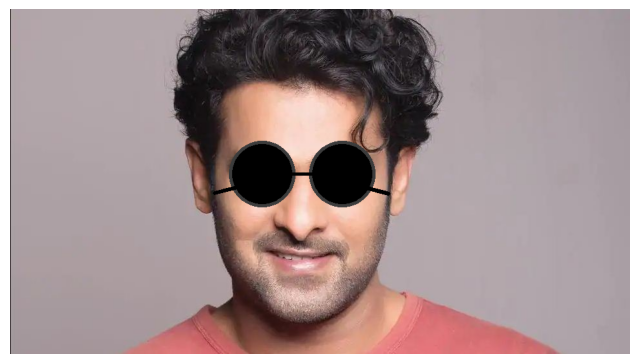

In [45]:
def process_image(data):
    img = cv2.imdecode(np.frombuffer(data, np.uint8), cv2.IMREAD_COLOR)
    out = SunglassesDrawer().draw(img.copy())
    plt.figure(figsize=(8,8))
    plt.imshow(cv2.cvtColor(out, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    return out

uploaded = files.upload()
for fname, content in uploaded.items():
    out_img = process_image(content)
    cv2.imwrite(f"sunglasses_{fname}", out_img)
    print("Saved:", f"sunglasses_{fname}")


In [54]:
def process_image(data):
    img = cv2.imdecode(np.frombuffer(data, np.uint8), cv2.IMREAD_COLOR)
    out = SunglassesDrawer().draw(img.copy())
    plt.figure(figsize=(8,8))
    plt.imshow(cv2.cvtColor(out, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    return out

Saving Prabhas-image.jpg to Prabhas-image (4).jpg
Saved: sunglasses_Prabhas-image (4).jpg


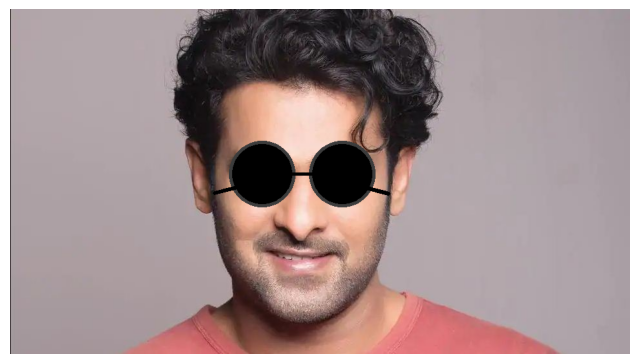

In [57]:
uploaded = files.upload()
for fname, content in uploaded.items():
    out_img = process_image(content)
    cv2.imwrite(f"sunglasses_{fname}", out_img)
    print("Saved:", f"sunglasses_{fname}")